<a href="https://colab.research.google.com/github/snehahs03/medical-image-analysis/blob/main/Copy_of_Densenet_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
%cd /content/drive/MyDrive/medical-image-analysis

/content/drive/MyDrive/medical-image-analysis


In [5]:
!git clone https://github.com/snehahs03/medical-image-analysis.git

fatal: destination path 'medical-image-analysis' already exists and is not an empty directory.


In [6]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.densenet import DenseNet201
%matplotlib inline
import matplotlib.pyplot as plt

import json
import math
import cv2
from PIL import Image
from keras.applications.densenet import DenseNet201, preprocess_input
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Sequential
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools

In [7]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

eczema_train = np.array(Dataset_loader("/content/drive/MyDrive/medical-image-analysis/test/Eczema Photos", 224))
melonoma_train = np.array(Dataset_loader("/content/drive/MyDrive/medical-image-analysis/train/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_train = np.array(Dataset_loader("/content/drive/MyDrive/medical-image-analysis/train/Psoriasis pictures Lichen Planus and related diseases",224))
eczema_test = np.array(Dataset_loader("/content/drive/MyDrive/medical-image-analysis/test/Eczema Photos",224))
melonoma_test = np.array(Dataset_loader("/content/drive/MyDrive/medical-image-analysis/test/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_test = np.array(Dataset_loader("/content/drive/MyDrive/medical-image-analysis/test/Psoriasis pictures Lichen Planus and related diseases", 224))

#labelling 
eczema_train_label = np.full(len(eczema_train),0)
melonoma_train_label = np.full(len(melonoma_train),1)
psoriasis_train_label = np.full(len(psoriasis_train),2)
eczema_test_label = np.full(len(eczema_test),0)
melonoma_test_label = np.full(len(melonoma_test),1)
psoriasis_test_label = np.full(len(psoriasis_test),2)

X_train = np.concatenate((eczema_train, melonoma_train, psoriasis_train), axis=0)
Y_train = np.concatenate((eczema_train_label, melonoma_train_label, psoriasis_train_label), axis=0)

X_test = np.concatenate((eczema_test, melonoma_test, psoriasis_test), axis=0)
Y_test = np.concatenate((eczema_test_label, melonoma_test_label, psoriasis_test_label), axis = 0)


s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]
 

#train and evaluation split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=42
)

100%|██████████| 352/352 [01:41<00:00,  3.47it/s]


In [8]:
X_train.shape, X_val.shape

((1047, 224, 224, 3), (262, 224, 224, 3))

In [9]:
Y_train.shape, Y_val.shape

((1047,), (262,))

In [10]:
Y_train = to_categorical(Y_train, num_classes=3)
Y_val = to_categorical(Y_val, num_classes=3)

In [11]:
pre_trained_model = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

74850304/74836368 [==============================] - 1s 0us/step


In [12]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3_b

In [13]:
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 1920)


In [14]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x)

# Configure and compile the model

model2 = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [17]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [18]:
batch_size = 64
epochs = 3
history2 = model2.fit_generator(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
16/16 [==============================] - 127s 2s/step - loss: 3.0910 - accuracy: 0.3921 - val_loss: 566452090860582594584946671616.0000 - val_accuracy: 0.4297
Epoch 2/3
16/16 [==============================] - 15s 885ms/step - loss: 2.3119 - accuracy: 0.4369 - val_loss: 2929066764140544.0000 - val_accuracy: 0.4688
Epoch 3/3
16/16 [==============================] - 15s 896ms/step - loss: 1.7332 - accuracy: 0.5115 - val_loss: 993816640.0000 - val_accuracy: 0.4609


In [19]:
for layer in pre_trained_model.layers[511:]:
    layer.trainable = True

In [20]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [22]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [23]:
batch_size = 64
epochs = 30
history2 = model2.fit_generator(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
16/16 [==============================] - 68s 2s/step - loss: 1.3391 - acc: 0.5740 - val_loss: 581513.8750 - val_acc: 0.1797
Epoch 2/30
16/16 [==============================] - 15s 894ms/step - loss: 1.0696 - acc: 0.6687 - val_loss: 9371.6816 - val_acc: 0.2266
Epoch 3/30
16/16 [==============================] - 15s 884ms/step - loss: 0.8524 - acc: 0.6618 - val_loss: 218.1065 - val_acc: 0.2266
Epoch 4/30
16/16 [==============================] - 15s 891ms/step - loss: 0.7638 - acc: 0.7186 - val_loss: 14.1339 - val_acc: 0.2344
Epoch 5/30
16/16 [==============================] - 14s 868ms/step - loss: 0.6385 - acc: 0.7595 - val_loss: 1.4305 - val_acc: 0.4922
Epoch 6/30
16/16 [==============================] - 15s 899ms/step - loss: 0.5851 - acc: 0.7558 - val_loss: 0.9893 - val_acc: 0.5703
Epoch 7/30
16/16 [==============================] - 15s 889ms/step - loss: 0.5180 - acc: 0.7816 - val_loss: 0.9395 - val_acc: 0.6328
Epoch 8/30
16/16 [==============================] - 15s 890ms

In [24]:
loss_val, acc_val = model2.evaluate(X_val, Y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

9/9 [==============================] - 17s 352ms/step - loss: 0.6851 - acc: 0.7824
Validation: accuracy = 0.782443  ;  loss_v = 0.685086


In [25]:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]
Y_test = to_categorical(Y_test, num_classes= 3)
loss_test, acc_test = model2.evaluate(X_test, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

31/31 [==============================] - 7s 216ms/step - loss: 0.5557 - acc: 0.8262
Test: accuracy = 0.826176  ;  loss = 0.555700


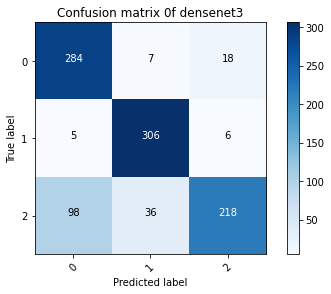

In [26]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix 0f densenet3',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model2.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

Text(0.5, 1.0, 'Training and validation loss')

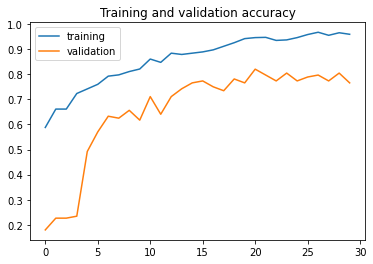

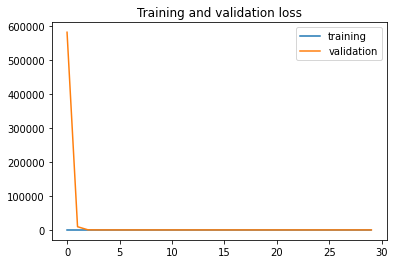

In [27]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [28]:
np.save('history2_Dnet2.npy', history2.history)

In [29]:
model2.save('Dnet2_model2.h5')